# WORK 1
Hanxue Yu . 2023/3/14

## Module 导入

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import grubbs

## 数据初读取&原始数据可视化

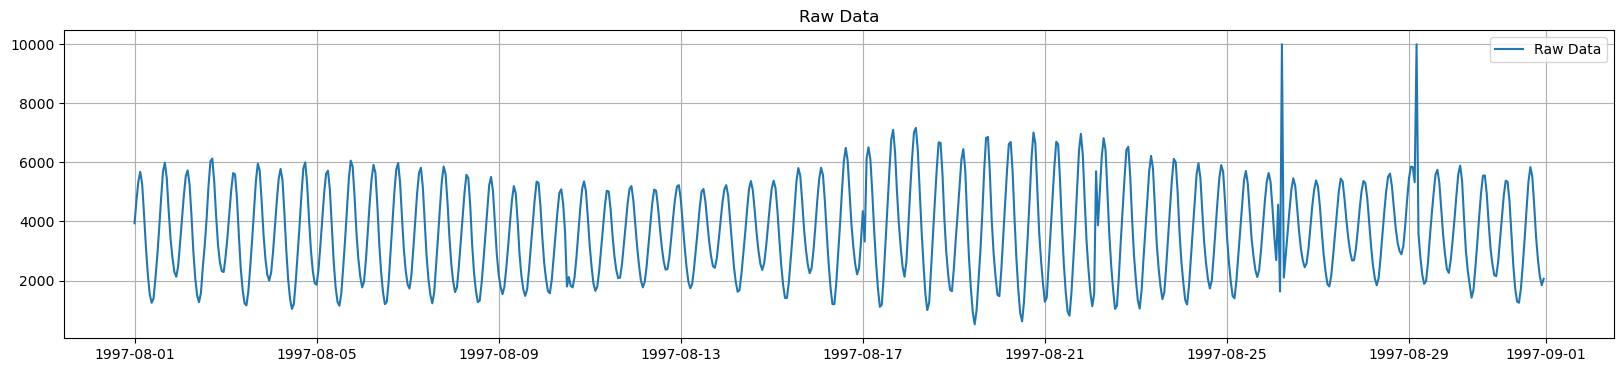

In [2]:
# 数据读取
datas=[]
dates=[]
for i in open('XM.txt').readlines()[6:]:
    sp=i.split()
    for i in range(24):
        dates.append(f'{sp[0]}-{sp[1]}-{sp[2]} {i:0>2}:00')
    datas.extend(sp[3:])
datas=np.array(list(map(int,datas)))
dates=pd.to_datetime(np.unique(dates))
# 可视化
plt.figure(figsize=[20,4])
plt.plot(dates,datas,label='Raw Data')
plt.title('Raw Data')
plt.legend();plt.grid();plt.show()

## 统计特性检验
### 处理1：莱因达准则

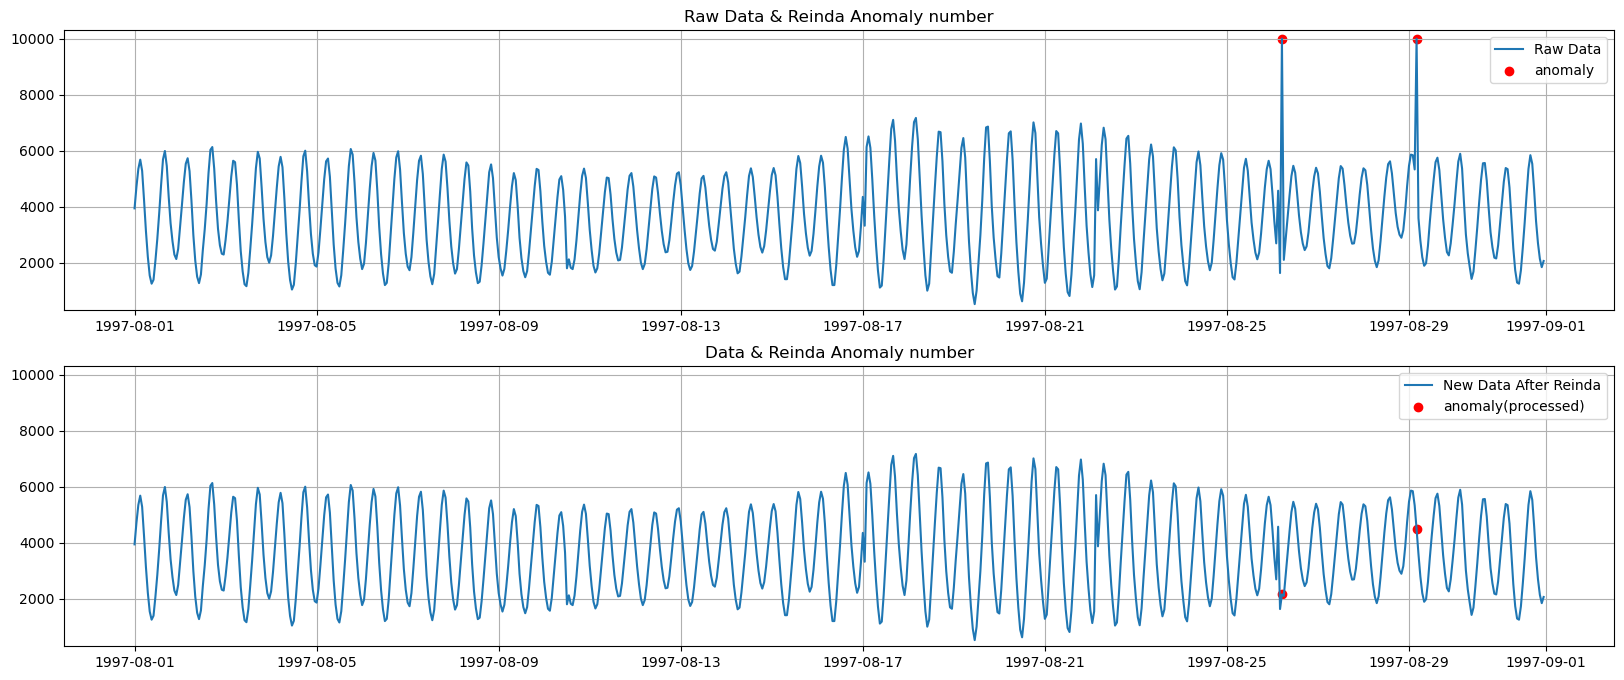

In [3]:
def GetReindaAno(d):
  """
  返回数据值根据莱因达准则计算的异常值的逻辑索引
  Parameters:
    d - 原始数据
  Returns:
  	异常值的逻辑索引
  """
  return (np.abs(d-np.mean(d))-3*np.std(d)>=0)

def inter(x,data):
  """
  三次样条插值
  Parameters:
    x - 异常值索引
    data - 原始数据
  Returns:
  	插值结果
  """
  f=interpolate.interp1d([1,2,8,9],np.concatenate([data[x-4:x-2],datas[x+3:x+5]]),kind='cubic')
  return f(5)
anos=[]
datas_1=np.copy(datas)
for i in dates[GetReindaAno(datas)]:
  ind=np.where(dates==i)[0][0]
  anos.append(ind)
  datas_1[ind]=inter(ind,datas)

plt.figure(figsize=[20,8])
plt.subplot(2,1,1)
plt.title('Raw Data & Reinda Anomaly number')
plt.plot(dates,datas,label='Raw Data')
plt.scatter(dates[GetReindaAno(datas)],datas[GetReindaAno(datas)],c='r',label='anomaly')
plt.ylim(300,10300)
plt.legend();plt.grid()
plt.subplot(2,1,2)
plt.title('Data & Reinda Anomaly number')
plt.plot(dates,datas_1,label='New Data After Reinda')
plt.scatter(dates[GetReindaAno(datas)],datas_1[GetReindaAno(datas)],c='r',label='anomaly(processed)')
plt.ylim(300,10300)
plt.legend();plt.grid()
plt.show()

### 处理2 格林布斯准则

In [4]:
# 格林布斯准则
ind=grubbs.max_test_indices(datas_1,0.1)
print(ind)
## 由于输出值为[],说明再进行莱因达准则异常值处理后已无格林布斯准则可判断的异常值

[]


## 连续性检验
### 梯度检测（变率检测）& 尖峰检测
 - 根据GB/T 14914 梯度检测的梯度检验参数根据要素类型、观测时间间隔、空间距离、观测时间和区域等因素确定。在所给条件中无法获得，因此采用将梯度数据再带入统计特性检验的方式。[1]


[1]GB/T 14914.6-2021, 海洋观测规范　第6部分：数据处理与质量控制[S].

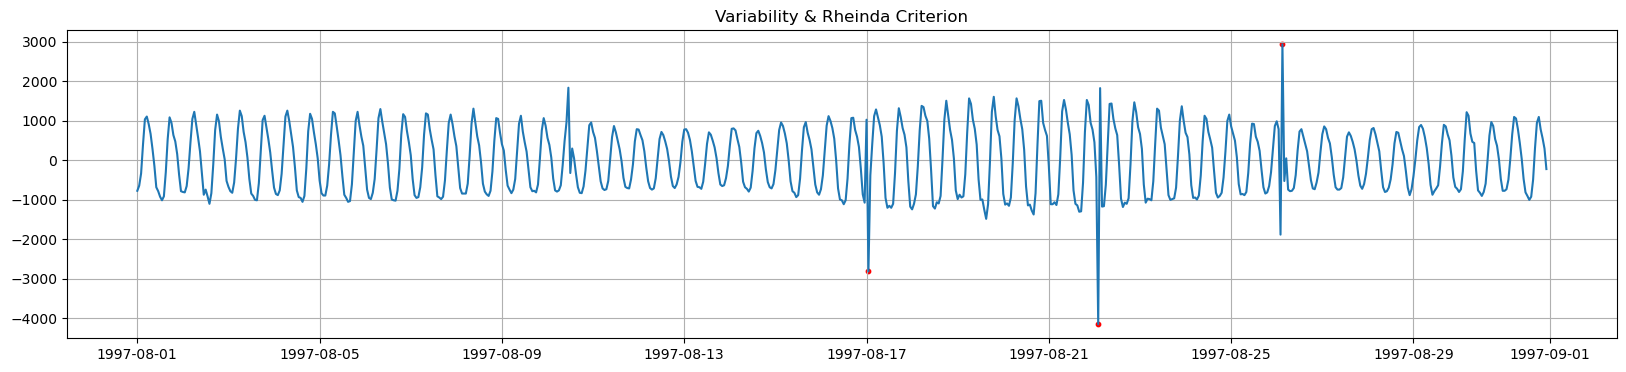

In [5]:
# 对梯度（变率数据）的莱因达准则&格林布斯准则
k=datas_1[:-1]-datas_1[1:]
plt.figure(figsize=[20,4])
plt.plot(dates[:-1],k)
plt.scatter(dates[:-1][GetReindaAno(k)],k[GetReindaAno(k)],c='r',s=10)
#plt.scatter(dates[:-1][grubbs.max_test_indices(k,0.1)],k[grubbs.max_test_indices(k,0.1)],c='r',s=10)
plt.title('Variability & Rheinda Criterion')
plt.grid()

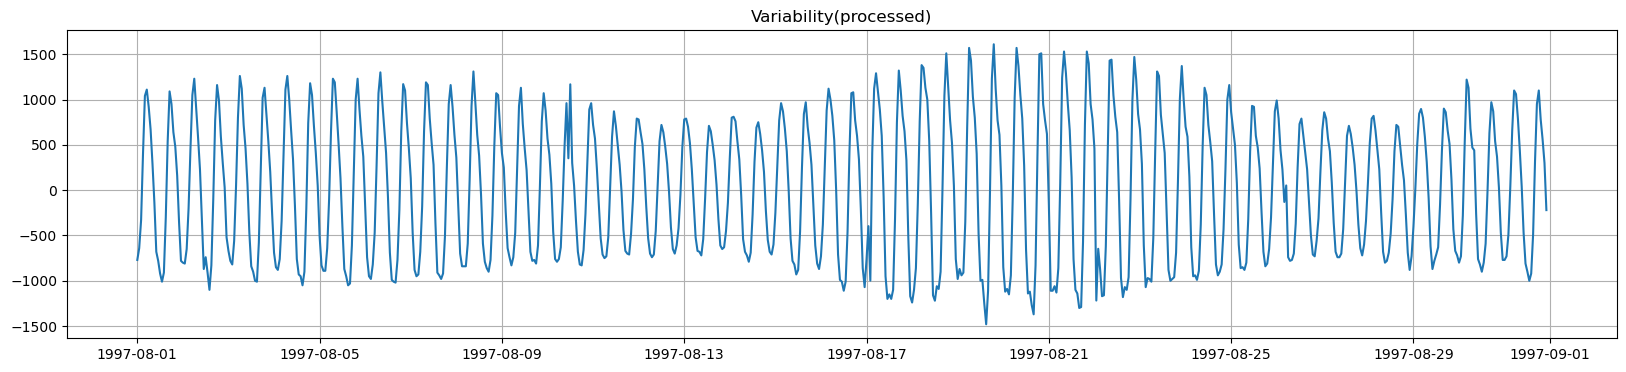

In [6]:
datas_2=np.copy(datas_1)
for i in dates[:-1][GetReindaAno(k)]:
  ind=np.where(dates==i)[0][0]
  datas_2[ind]=inter(ind,datas_1)
  anos.append(ind)
for i in dates[:-1][GetReindaAno(k)]:
  ind=np.where(dates==i)[0][0]
  datas_2[ind+1]=inter(ind+1,datas_1)
  anos.append(ind+1)
k_1=datas_2[:-1]-datas_2[1:]
for i in dates[:-1][GetReindaAno(k_1)]:
  ind=np.where(dates==i)[0][0]
  datas_2[ind]=inter(ind,datas_1)
  anos.append(ind)
k_1=np.abs(datas_2[:-1]-datas_2[1:])
for i in dates[:-1][GetReindaAno(k_1)]:
  ind=np.where(dates==i)[0][0]
  datas_2[ind+1]=inter(ind+1,datas_1)
  anos.append(ind+1)
k_1=datas_2[:-1]-datas_2[1:]

plt.figure(figsize=[20,4])
plt.plot(dates[:-1],k_1)
plt.scatter(dates[:-1][GetReindaAno(k_1)],k_1[GetReindaAno(k_1)],c='r',s=10)
#plt.xlim(dates[(dates.month==8)&(dates.day==25)][0],dates[-1])
plt.title('Variability(processed)')
plt.grid()

## 最终结果

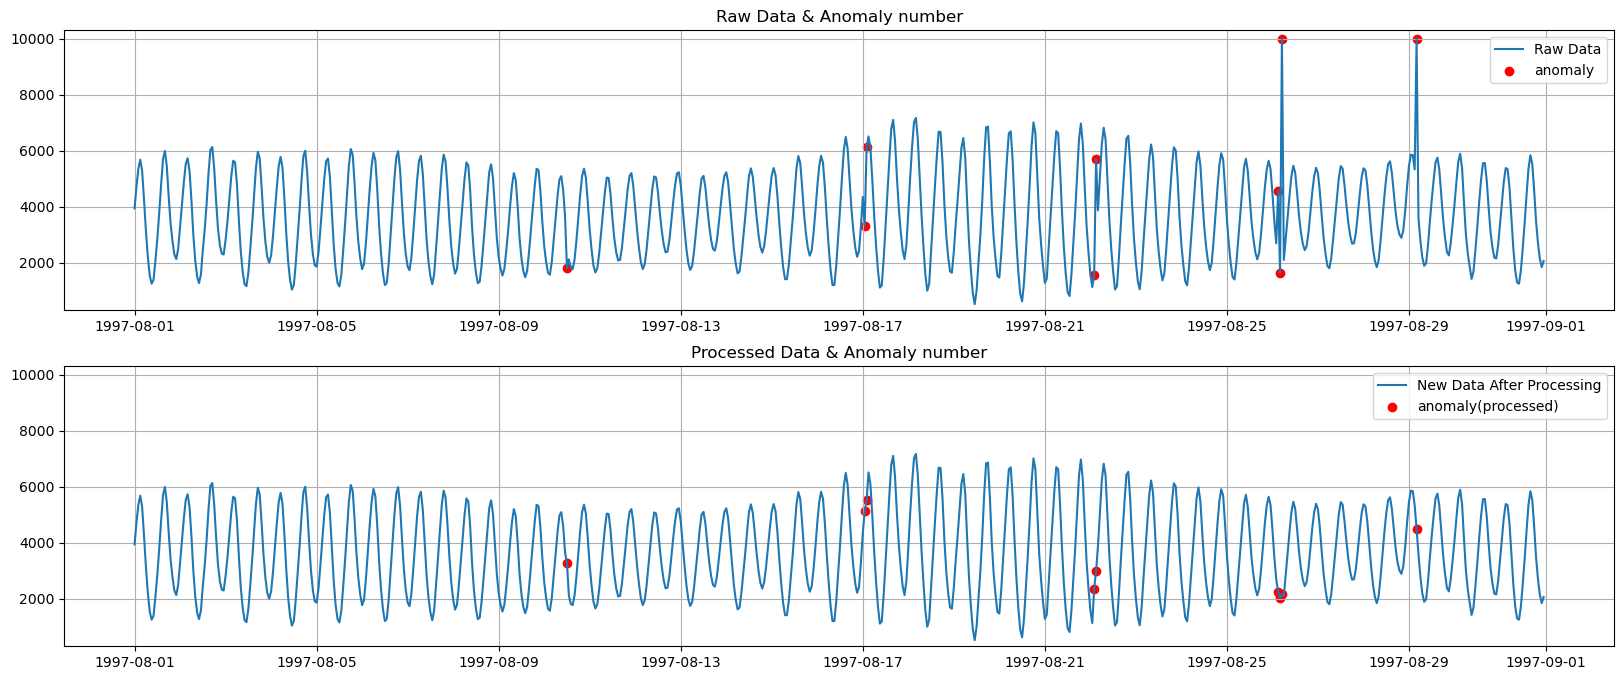

In [10]:
plt.figure(figsize=[20,8])
plt.subplot(2,1,1)
plt.title('Raw Data & Anomaly number')
plt.plot(dates,datas,label='Raw Data')
plt.scatter(dates[np.unique(anos)],datas[np.unique(anos)],c='r',label='anomaly')
plt.ylim(300,10300)
plt.legend();plt.grid()
plt.subplot(2,1,2)
plt.title('Processed Data & Anomaly number')
plt.plot(dates,datas_2,label='New Data After Processing')
plt.scatter(dates[np.unique(anos)],datas_2[np.unique(anos)],c='r',label='anomaly(processed)')
plt.ylim(300,10300)
plt.legend();plt.grid()
plt.savefig('results.png')

In [8]:
print(f'      原始数据|处理数据')
print(f'  均值：{np.mean(datas):7.2f}|{np.mean(datas_2):.2f}')
print(f'标准差：{np.std(datas):7.2f}|{np.std(datas_2):.2f}')

      原始数据|处理数据
  均值：3656.22|3636.69
标准差：1563.81|1525.29


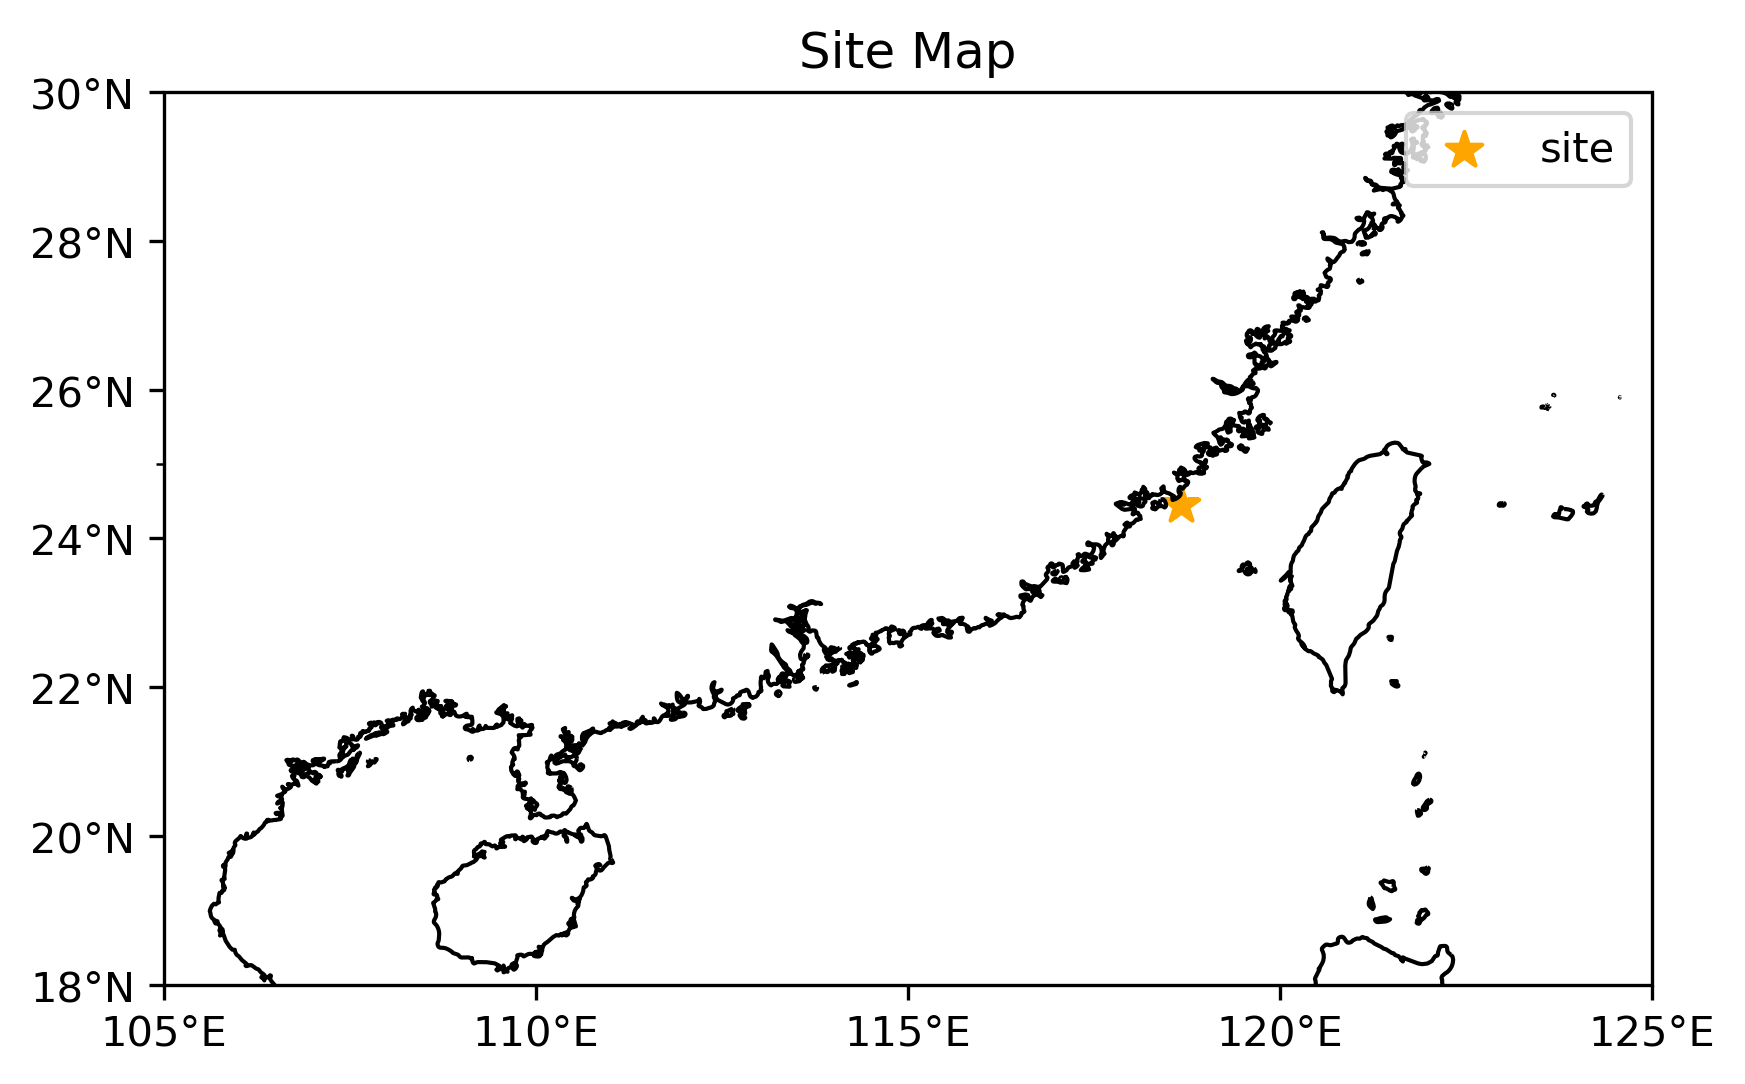

In [9]:
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
plt.figure(dpi=300)
ax=plt.axes(facecolor='white', projection=ccrs.PlateCarree(central_longitude=0))
ax.set_title('Site Map')
ax.set_xlim(105,125)
ax.set_ylim(18,30)
ax.scatter(118+40/60,24+27/60,c='Orange',marker='*',s=80,label='site')
ax.legend()
ax.set_xticks(np.arange(105,126,5))
ax.set_yticks(np.arange(18,31,2))
ax.xaxis.set_major_formatter(LongitudeFormatter())#刻度格式转换为经纬度样式 
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.xaxis.set_minor_locator(mticker.MultipleLocator(5))#刻度格式转换为经纬度样式 
ax.yaxis.set_minor_locator(mticker.MultipleLocator(5))
ax.coastlines()
plt.show()